# ML4T Workflow with zipline

We can also integrate the model training into our backtest. The goal is to replicate the daily return predictions we used in [backtesting_with_zipline](02_backtesting_with_zipline.ipynb) and generated in [Chapter 7](../../07_linear_models). 

We will, however, use a few additional Pipeline factors to illustrate their usage. The principal new element is a CustomFactor that receives features and returns as inputs to train a model and produce predictions. We follow the workflow displayed in the following figure:

![ML4T with Zipline](../../assets/zip_pipe_model_flow.png "ML4T Workflow with Zipline")

## Imports and Settings

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from logbook import Logger, StderrHandler, INFO

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, EWMA, Returns
from zipline.pipeline.factors.technical import RSI, MACDSignal, TrueRange
from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission,
                         record,
                         order_target, order_target_percent)

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [3]:
sns.set_style('whitegrid')

### Logging Setup

In [4]:
log_handler = StderrHandler(
        format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                      '{record.level_name}: {record.func_name}: {record.message}',
        level=INFO
)
log_handler.push_application()
log = Logger('Algorithm')

### Algo Parameters

In [5]:
# Target long/short positions
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15

UNIVERSE = 250

# Length of the training period (memory-intensive due to pre-processing)
TRAINING_PERIOD = 252 * 2

# train to predict N day forward returns
N_FORWARD_DAYS = 1

# How often to trade; align with prediction horizon
# for weekly, set to date_rules.week_start(days_offset=1)
TRADE_FREQ = date_rules.every_day()  

In [6]:
start = pd.Timestamp('2015-01-01', tz='UTC')
end = pd.Timestamp('2017-12-31', tz='UTC')

## Factor Engineering

To create a Pipeline Factor, we need one or more input variables, a window_length that indicates the number of most recent data points for each input and security, and the computation we want to conduct.

We will use ten custom and built-in factors as features for our model to capture risk factors like momentum and volatility. Next, we’ll come up with a CustomFactor that trains our model.

### Momentum

In [7]:
def Price_Momentum_3M():
    return Returns(window_length=63)

In [8]:
def Returns_39W():
    return Returns(window_length=215)

### Volatility

In [9]:
class Vol_3M(CustomFactor):
    # 3 months volatility
    inputs = [Returns(window_length=2)]
    window_length = 63

    def compute(self, today, assets, out, rets):
        out[:] = np.nanstd(rets, axis=0)

### Mean Reversion

In [10]:
class Mean_Reversion_1M(CustomFactor):
    # standardized difference between latest monthly return
    # and their annual average 
    inputs = [Returns(window_length=21)]
    window_length = 252

    def compute(self, today, assets, out, monthly_rets):
        out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                 np.nanstd(monthly_rets, axis=0)

### Money Flow Volume

In [11]:
class Moneyflow_Volume_5d(CustomFactor):
    inputs = [USEquityPricing.close, USEquityPricing.volume]
    window_length = 5

    def compute(self, today, assets, out, close, volume):

        mfvs = []

        for col_c, col_v in zip(close.T, volume.T):

            # denominator
            denominator = np.dot(col_c, col_v)

            # numerator
            numerator = 0.
            for n, price in enumerate(col_c.tolist()):
                if price > col_c[n - 1]:
                    numerator += price * col_v[n]
                else:
                    numerator -= price * col_v[n]

            mfvs.append(numerator / denominator)
        out[:] = mfvs

### Price Trend

A linear price trend that we estimate using linear regression (see [Chapter 7](../../07_linear_models) works as follows: we use the 252 latest close prices to compute the regression coefficient on a linear time trend:

In [12]:
class Trendline(CustomFactor):
    # linear 12 month price trend regression
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        X = np.arange(self.window_length).reshape(-1, 1).astype(float)
        X -= X.mean()
        Y = close - np.nanmean(close, axis=0)
        out[:] = (X.T @ Y / np.var(X)) / self.window_length

### Price Oscillator

In [13]:
class Price_Oscillator(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        four_week_period = close[-20:]
        out[:] = (np.nanmean(four_week_period, axis=0) /
                  np.nanmean(close, axis=0)) - 1.

### Combine Features

In [14]:
vol_3M = Vol_3M()
mean_reversion_1M = Mean_Reversion_1M()
macd_signal_10d = MACDSignal()
moneyflow_volume_5d = Moneyflow_Volume_5d()
trendline = Trendline()
price_oscillator = Price_Oscillator()
price_momentum_3M = Price_Momentum_3M()
returns_39W = Returns_39W()
true_range = TrueRange()

In [15]:
features = {
    'Vol 3M'             : vol_3M,
    'Mean Reversion 1M'  : mean_reversion_1M,
    'MACD Signal 10d'    : macd_signal_10d,
    'Moneyflow Volume 5D': moneyflow_volume_5d,
    'Trendline'          : trendline,
    'Price Oscillator'   : price_oscillator,
    'Price Momentum 3M'  : price_momentum_3M,
    '39 Week Returns'    : returns_39W,
    'True Range'         : true_range
}

## ML CustomFactor

Our `CustomFactor` called LinearModel will have the `StandardScaler` and a stochastic gradient descent (SGD) implementation of ridge regression as instance attributes, and we will train the model on three days a week.

- The `compute` method generates predictions (addressing potential missing values), but first checks if the model should be trained.
- The `_train_model` method is the centerpiece of the puzzle. It shifts the returns and aligns the resulting forward returns with the Factor features, removing missing values in the process. It scales the remaining data points and trains the linear SGDRegressor.

In [16]:
class LinearModel(CustomFactor):
    """Obtain model predictions"""
    train_on_weekday = [0, 2, 4]

    def __init__(self, *args, **kwargs):
        super().__init__(self, *args, **kwargs)

        self._scaler = StandardScaler()
        self._model = SGDRegressor(penalty='L2')
        self._trained = False

    def _train_model(self, today, returns, inputs):

        scaler = self._scaler
        model = self._model

        shift_by = N_FORWARD_DAYS + 1
        outcome = returns[shift_by:].flatten()
        features = np.dstack(inputs)[:-shift_by]
        n_days, n_stocks, n_features = features.shape
        features = features.reshape(-1, n_features)
        features = features[~np.isnan(outcome)]
        outcome = outcome[~np.isnan(outcome)]
        outcome = outcome[np.all(~np.isnan(features), axis=1)]
        features = features[np.all(~np.isnan(features), axis=1)]
        features = scaler.fit_transform(features)

        start = time()
        model.fit(X=features, y=outcome)
#         log.info('{} | {:.2f}s'.format(today.date(), time() - start))
        self._trained = True

    def _maybe_train_model(self, today, returns, inputs):
        if (today.weekday() in self.train_on_weekday) or not self._trained:
            self._train_model(today, returns, inputs)

    def compute(self, today, assets, out, returns, *inputs):
        self._maybe_train_model(today, returns, inputs)

        # Predict most recent feature values
        X = np.dstack(inputs)[-1]
        missing = np.any(np.isnan(X), axis=1)
        X[missing, :] = 0
        X = self._scaler.transform(X)
        preds = self._model.predict(X)
        out[:] = np.where(missing, np.nan, preds)

## Pipeline

The `make_ml_pipeline()` function preprocesses and combines the outcome, feature, and model parts into a Pipeline with a column for predictions.

In [17]:
def make_ml_pipeline(universe, window_length=21, n_forward_days=5):
    pipeline_columns = OrderedDict()

    # ensure that returns is the first input
    pipeline_columns['Returns'] = Returns(inputs=[USEquityPricing.open],
                                          mask=universe,
                                          window_length=n_forward_days + 1)

    # convert factors to ranks; append to pipeline
    pipeline_columns.update({k: v.rank(mask=universe)
                             for k, v in features.items()})

    # Create ML pipeline factor.
    # window_length = length of the training period
    pipeline_columns['predictions'] = LinearModel(inputs=pipeline_columns.values(),
                                         window_length=window_length + n_forward_days,
                                         mask=universe)

    return Pipeline(screen=universe, columns=pipeline_columns)

## Universe

In [18]:
def make_universe():
    # Set screen
    dollar_volume = AverageDollarVolume(window_length=90)
    return dollar_volume.top(UNIVERSE)

In [19]:
universe = make_universe()

## Initialize Algorithm

In [20]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0, min_trade_cost=0))

    schedule_function(rebalance, TRADE_FREQ,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30),
    )

    schedule_function(record_vars, date_rules.every_day(),
                      time_rules.market_close())

    ml_pipeline = make_ml_pipeline(universe,
                                   n_forward_days=N_FORWARD_DAYS,
                                   window_length=TRAINING_PERIOD)

    # Create our dynamic stock selector.
    attach_pipeline(ml_pipeline, 'ml_model')

    context.past_predictions = {}
    context.ic = 0
    context.rmse = 0
    context.mae = 0
    context.returns_spread_bps = 0

## Evaluate Predictive Accuracy

The `evaluate_predictions()` function does exactly this: it tracks the past predictions of our model and evaluates them once returns for the relevant time horizon materialize (in our example the next day):

In [21]:
def evaluate_predictions(output, context):
    # Look at past predictions to evaluate model performance
    # A day has passed, shift days and drop old ones
    context.past_predictions = {
        k - 1: v for k, v in context.past_predictions.items() if k > 0
    }

    if 0 in context.past_predictions:
        
        # Use today's n-day returns to evaluate predictions
        returns, predictions = (output['Returns'].dropna()
                                .align(context.past_predictions[0].dropna(),
                                       join='inner'))
        if len(returns) > 0 and len(predictions) > 0:
            context.ic = spearmanr(returns, predictions)[0]
            context.rmse = np.sqrt(
                mean_squared_error(returns, predictions))
            context.mae = mean_absolute_error(returns, predictions)

            long_rets = returns[predictions > 0].mean()
            short_rets = returns[predictions < 0].mean()
            context.returns_spread_bps = (long_rets - short_rets) * 10000

    # Store current predictions
    context.past_predictions[N_FORWARD_DAYS] = context.predicted_returns

## Get Pipeline Output

We obtain new predictions using the `before_trading_start()` function that runs every morning before market open:

In [38]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('ml_model')
    context.predicted_returns = output['predictions']
    context.predicted_returns.index.set_names(['equity'], inplace=True)

    evaluate_predictions(output, context)

    # These are the securities that we are interested in trading each day.
    context.security_list = context.predicted_returns.index

## Rebalance

In [39]:
def rebalance(context, data):
    """
    Execute orders according to our schedule_function() timing.
    """
    predictions = context.predicted_returns

    # Drop stocks that can not be traded
    predictions = predictions.loc[data.can_trade(predictions.index)]
    longs = (predictions[predictions > 0]
             .sort_values(ascending=False)[:N_LONGS]
             .index
             .tolist())
    shorts = (predictions[predictions < 0]
              .sort_values()[:N_SHORTS]
              .index
              .tolist())
    targets = set(longs + shorts)
    for position in context.portfolio.positions:
        if position not in targets:
            order_target(position, 0)
    
    n_longs, n_shorts = len(longs), len(shorts)
    if n_longs > MIN_POSITIONS and n_shorts > MIN_POSITIONS:
        for stock in longs:
            order_target_percent(stock, target=1/n_longs)
        for stock in shorts:
            order_target_percent(stock, target=-1/n_shorts)
    else:
        for stock in targets:
            if stock in context.portfolio.positions:
                order_target(stock, 0)

## Logging

In [40]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(
            leverage=context.account.leverage,
            ic=context.ic,
            rmse=context.rmse,
            mae=context.mae,
            returns_spread_bps=context.returns_spread_bps
    )

## Run Algo

In [41]:
go = time()
results = run_algorithm(start=start,
                        end=end,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e6,
                        data_frequency='daily',
                        benchmark_returns=None,
                        bundle='quandl')

print('{:.2f}'.format(time()-go))

[2021-04-15 20:35:21.712263]: WARNING: _can_order_asset: Cannot place order for COV, as it has de-listed. Any existing positions for this asset will be liquidated on 2015-01-27 00:00:00+00:00.
[2021-04-15 20:35:31.205477]: INFO: handle_split: after split: asset: Equity(2509 [SBUX]), amount: 826, cost_basis: 47.04, last_sale_price: 95.23
[2021-04-15 20:35:31.205864]: INFO: handle_split: returning cash: 0.0
[2021-04-15 20:36:09.732804]: WARNING: _can_order_asset: Cannot place order for CTRX, as it has de-listed. Any existing positions for this asset will be liquidated on 2015-07-24 00:00:00+00:00.
[2021-04-15 20:36:31.022819]: INFO: handle_split: after split: asset: Equity(1992 [NKE]), amount: 526, cost_basis: 65.92, last_sale_price: 128.71
[2021-04-15 20:36:31.023204]: INFO: handle_split: returning cash: 0.0
[2021-04-15 20:36:58.833296]: WARNING: _can_order_asset: Cannot place order for ACE, as it has de-listed. Any existing positions for this asset will be liquidated on 2016-01-15 00:0

313.17


## Analyze using PyFolio

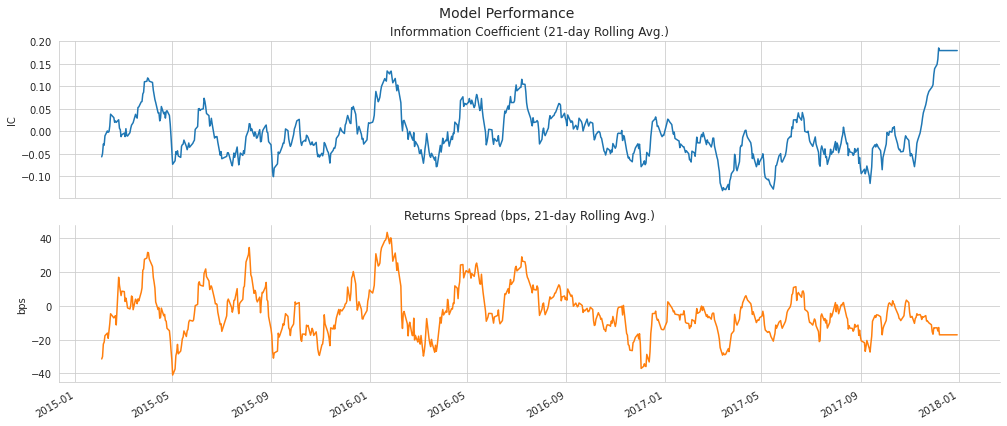

In [42]:
axes = (results[['ic', 'returns_spread_bps']]
        .dropna()
        .rolling(21)
        .mean()
        .plot(subplots=True, 
              layout=(2,1), 
              figsize=(14, 6), 
              title=['Informmation Coefficient (21-day Rolling Avg.)', 'Returns Spread (bps, 21-day Rolling Avg.)'],
              legend=False))
axes = axes.flatten()
axes[0].set_ylabel('IC')
axes[1].set_ylabel('bps')
plt.suptitle('Model Performance', fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.9);

### Get PyFolio Input

In [43]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

### Get Benchmark Data

In [44]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Performance Plots

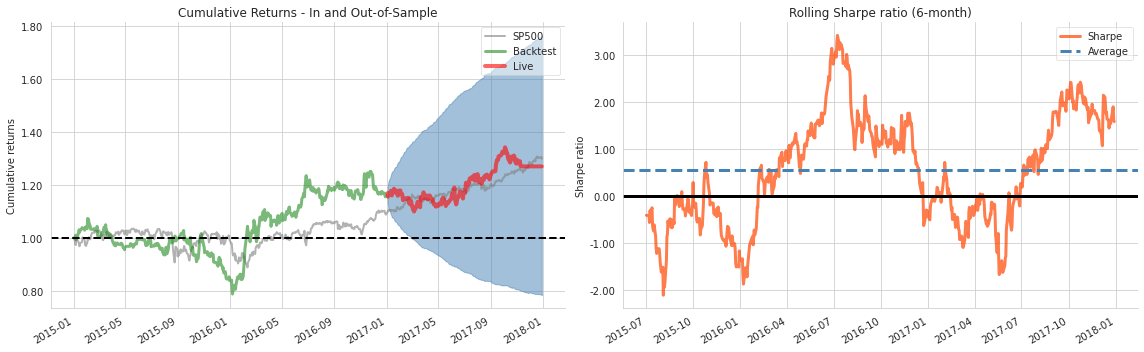

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2017-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1])
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
sns.despine()
fig.tight_layout();

### Full Tearsheet

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.58,2015-02-03,2016-01-07,2016-03-11,289
1,12.09,2016-11-25,2017-03-06,2017-09-05,203
2,8.88,2016-06-27,2016-08-03,2016-11-10,99
3,5.74,2016-03-22,2016-04-06,2016-05-17,41
4,5.36,2017-10-04,2017-11-10,NaT,NaN


Stress Events,mean,min,max
Fall2015,-0.03%,-3.49%,1.30%
New Normal,0.04%,-4.56%,4.43%


Top 10 long positions of all time,max
sid,
URI,7.95%
CI,7.76%
GMCR,6.62%
SUNE,5.48%
ENDP,4.90%
BBY,4.83%
SRPT,4.82%
VRTX,4.82%
CHK,4.75%


Top 10 short positions of all time,max
sid,
T,-8.33%
KHC,-8.22%
EFX,-8.20%
SLB,-8.15%
MDLZ,-8.13%
CTL,-7.73%
ALTR,-6.57%
JNJ,-6.55%
AVGO,-6.53%


Top 10 positions of all time,max
sid,
T,8.33%
KHC,8.22%
EFX,8.20%
SLB,8.15%
MDLZ,8.13%
URI,7.95%
CI,7.76%
CTL,7.73%
GMCR,6.62%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,25540.00,12820.00,12720.00
Percent profitable,0.50,0.47,0.52
Winning round_trips,12743.00,6066.00,6677.00
Losing round_trips,12670.00,6699.00,5971.00
Even round_trips,127.00,55.00,72.00


PnL stats,All trades,Short trades,Long trades
Total profit,$256082.29,$-113461.35,$369543.64
Gross profit,$7577287.72,$3784061.93,$3793225.79
Gross loss,$-7321205.44,$-3897523.28,$-3423682.15
Profit factor,$1.03,$0.97,$1.11
Avg. trade net profit,$10.03,$-8.85,$29.05
Avg. winning trade,$594.62,$623.82,$568.10
Avg. losing trade,$-577.84,$-581.81,$-573.39
Ratio Avg. Win:Avg. Loss,$1.03,$1.07,$0.99
Largest winning trade,$23595.93,$22787.73,$23595.93
Largest losing trade,$-19045.75,$-14869.12,$-19045.75


Duration stats,All trades,Short trades,Long trades
Avg duration,2 days 06:47:16.303837118,2 days 07:32:26.021840873,2 days 06:01:45.283018867
Median duration,2 days 00:00:00,2 days 00:00:00,2 days 00:00:00
Longest duration,56 days 00:00:00,56 days 00:00:00,34 days 00:00:00
Shortest duration,0 days 21:00:00,0 days 21:00:00,0 days 21:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,0.00%,0.00%
Avg returns winning,0.06%,0.05%,0.06%
Avg returns losing,-0.05%,-0.05%,-0.05%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.03%,0.03%,0.03%
Median returns losing,-0.03%,-0.03%,-0.03%
Largest winning trade,2.55%,1.97%,2.55%
Largest losing trade,-1.94%,-1.94%,-1.22%


Symbol stats,AAL,AAOI,AAP,AAPL,ABBV,ABC,ABT,ACE,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEP,AET,AGN,AIG,AKS,ALB,ALGN,ALL,ALTR,ALXN,AMAT,AMBA,AMD,AMGN,AMP,AMT,AMZN,ANAC,ANTM,APA,APC,APD,ARG,ARIA,ARNC,ATVI,AVGO,AXP,AYI,AZO,BA,BAC,BAX,BBBY,BBT,BBY,BCR,BDX,BHI,BIDU,BIIB,BK,BLK,BMRN,BMY,BP,BRCM,BRK_B,BSX,C,CAH,CAM,CAT,CB,CBS,CBST,CCE,CCI,CCL,CELG,CF,CFG,CFN,CHK,CHTR,CI,CL,CLF,CLR,CMCSA,CMCSK,CME,CMG,CMI,CNC,COF,COG,COH,COL,COP,COST,COTY,COV,CRM,CSCO,CSX,CTL,CTRX,CTSH,CVC,CVS,CVX,CXO,D,DAL,DD,DE,DFS,DG,DHI,DHR,DIS,DISH,DLPH,DLR,DLTR,DOW,DPZ,DTV,DUK,DVN,EA,EBAY,ECL,EFX,EL,EMC,EMR,ENDP,EOG,EQIX,EQR,EQT,ESRX,ESV,ETN,EW,EXC,EXPE,F,FB,FCX,FDX,FIS,FITB,FL,FLT,FOXA,FTI,GD,GE,GILD,GIS,GLW,GM,GMCR,GOOG,GOOGL,GPS,GS,GWW,HAL,HBAN,HCA,HCN,HD,HES,HIG,HON,HOT,HP,HPE,HPQ,HSP,HST,HSY,HTZ,HUM,IBM,ICE,ILMN,INCY,INTC,INTU,IP,ISIS,ISRG,ITW,JAH,JBLU,JCI,JNJ,JNPR,JPM,JWN,K,KEY,KHC,KMB,KMI,KMX,KO,KORS,KR,KRFT,KSS,LB,LEN,LH,LLY,LMT,LNG,LNKD,LO,LOW,LRCX,LUV,LVLT,LVS,LYB,M,MA,MAC,MAR,MAT,MCD,MCHP,MCK,MDLZ,MDT,MDVN,MET,MGM,MJN,MLM,MMM,MNK,MNST,MO,MON,MOS,MPC,MRK,MRO,MS,MSFT,MU,MYL,NBL,NE,NEE,NEM,NFLX,NKE,NOC,NOV,NOW,NRG,NSC,NUE,NVDA,NWL,OCR,OKE,OMC,ORCL,ORLY,OXY,PANW,PCG,PCLN,PCP,PCYC,PEP,PFE,PG,PGR,PH,PLL,PM,PNC,PNRA,PPG,PPL,PRGO,PRU,PSA,PSX,PX,PXD,PYPL,Q,QCOM,RAD,RAI,RCL,RCPT,REGN,RF,RHT,RIG,RL,ROST,RRC,RTN,SBAC,SBUX,SCHW,SCTY,SDRL,SE,SHW,SIAL,SIG,SIRI,SKX,SLB,SLXP,SNDK,SNI,SO,SPG,SPGI,SPLK,SPLS,SRPT,STI,STJ,STT,STX,STZ,SUNE,SWKS,SWN,SYF,SYK,SYMC,SYY,T,TAP,TDG,TEL,TGT,TIF,TJX,TMO,TMUS,TRIP,TRV,TSLA,TSN,TSO,TSRO,TTWO,TWC,TWTR,TWX,TXN,UAA,UAL,ULTA,UNH,UNP,UPS,URI,USB,UTX,V,VFC,VIAB,VLO,VMC,VMW,VNTV,VOD,VRTX,VRX,VTR,VZ,WBA,WDAY,WDC,WFC,WFM,WHR,WLL,WMB,WMT,WWAV,WY,WYNN,X,XEC,XLNX,XOM,YELP,YHOO,YUM,ZBH,ZTS
Avg returns all round_trips,-0.00%,0.03%,0.02%,0.00%,0.02%,-0.00%,-0.01%,-0.02%,0.02%,0.01%,0.05%,-0.00%,0.02%,-0.02%,-0.04%,0.02%,-0.01%,-0.03%,-0.00%,-0.01%,-0.01%,0.00%,-0.00%,0.01%,0.02%,0.01%,-0.03%,-0.02%,0.02%,0.06%,-0.02%,-0.01%,-0.01%,-0.01%,-0.01%,0.01%,-0.00%,NaN,NaN,-0.00%,0.02%,-0.01%,-0.01%,0.01%,0.01%,0.01%,-0.00%,-0.00%,NaN,-0.00%,-0.01%,-0.05%,0.02%,0.01%,0.01%,-0.01%,0.00%,0.01%,0.01%,-0.02%,-0.02%,0.03%,-0.02%,-0.02%,0.03%,-0.01%,0.01%,0.02%,0.02%,0.04%,NaN,NaN,-0.01%,0.03%,-0.03%,-0.00%,0.02%,0.03%,0.01%,0.01%,0.01%,-0.04%,-0.07%,-0.00%,0.02%,0.01%,-0.06%,0.01%,-0.06%,0.19%,0.00%,-0.06%,-0.02%,-0.06%,-0.02%,0.01%,-0.06%,-0.12%,0.00%,0.03%,0.08%,0.00%,-0.04%,-0.02%,-0.04%,-0.04%,-0.03%,0.00%,-0.00%,0.01%,-0.01%,-0.01%,-0.02%,0.01%,-0.15%,0.01%,-0.01%,0.03%,-0.07%,0.02%,-0.01%,-0.02%,-0.01%,-0.02%,-0.00%,-0.01%,0.00%,-0.07%,0.02%,0.08%,0.01%,0.05%,-0.02%,0.01%,0.05%,0.01%,-0.26%,-0.02%,0.03%,0.01%,-0.01%,0.01%,0.07%,0.08%,0.01%,-0.03%,0.01%,0.00%,0.12%,0.03%,0.01%,-0.01%,-0.06%,-0.04%,0.02%,0.04%,0.03%,0.01%,0.02%,-0.03%,-0.02%,0.01%,-0.01%,-0.11%,-0.01%,0.03%,0.00%,-0.00%,-0.01%,-0.01%,-0.00%,0.01%,-0.00%,-0.00%,-0.01%,0.01%,0.01%,0.00%,0.02%,-0.01%,-0.02%,0.03%,0.03%,-0.01%,0.04%,-0.02%,0.00%,-0.00%,0.01%,0.02%,0.03%,-0.02%,0.03%,-0.03%,0.02%,0.01%,0.00%,-0.03%,0.01%,0.04%,0.03%,0.02%,-0.01%,0.04%,0.01%,0.01%,-0.01%,-0.01%,-0.01%,0.01%,-0.00%,-0.01%,0.01%,-0.01%,0.01%,-0.01%,-0.00%,-0.02%,0.04%,-0.02%,0.02%,-0.00%,-0.00%,0.01%,0.03%,0.00%,0.00%,0.00%,-0.01%,0.00%,-0.00%,0.01%,0.02%,-0.00%,0.00%,-0.06%,-0.02%,0.00%,0.01%,0.07%,-0.00%,-0.00%,-0.00%,-0.01%,-0.01%,0.00%,0.01%,-0.01%,-0.01%,-0.00%,0.03%,0.00%,-0.02%,0.00%,0.11%,0.01%,0.03%,0.01%,0.00%,-0.01%,-0.03%,-0.02%,-0.16%,-0.02%,0.01%,-0.01%,-0.01%,0.00%,-0.01%,-0.05%,0.01%,-0.01%,0.01%,-0.01%,-0.02%,0.01%,-0.02%,0.02%,0.01%,-0.01%,0.01%,0.13%,0.01%,-0.00%,-0.01%,-0.01%,0.02%,-0.01%,0.03%,-0.00%,-0.03%,-0.01%,-0.00%,0.00%,-0.00%,0.05%,-0.01%,-0.02%,0.01%,0.00%,-0.01%,-0.01%,-0.01%,0.01%,0.03%,0.01%,-0.02%,0.00%,0.00%,0.02%,0.00%,0.01%,-0.01%,0.01%,-0.02%,0.02%,-0.00%,0.01%,-0.02%,-0.00%,-0.00%,0.00%,0.01%,0.00%,-0.01%,-0.00%,-0.02%,-0.02%,-0.04%,0.02%,-0.00%,-0.01%,0.01%,-0.01%,0.01%,-0.00%,0.00%,0.01%,-0.01%,0.00%,-0.02%,0.01%,0.01%,0.01%,0.02%,0.04%,-0.03%,-0.03%,0.01%,-0.01%,0.02%,0.01%,0.01%,0.

Profitability (PnL / PnL total) per name,
symbol,
GMCR,15.86%
CMCSA,10.14%
HPE,10.13%
MCK,9.96%
HES,9.87%
REGN,9.86%
VRTX,9.58%
CLR,8.82%
MYL,7.76%


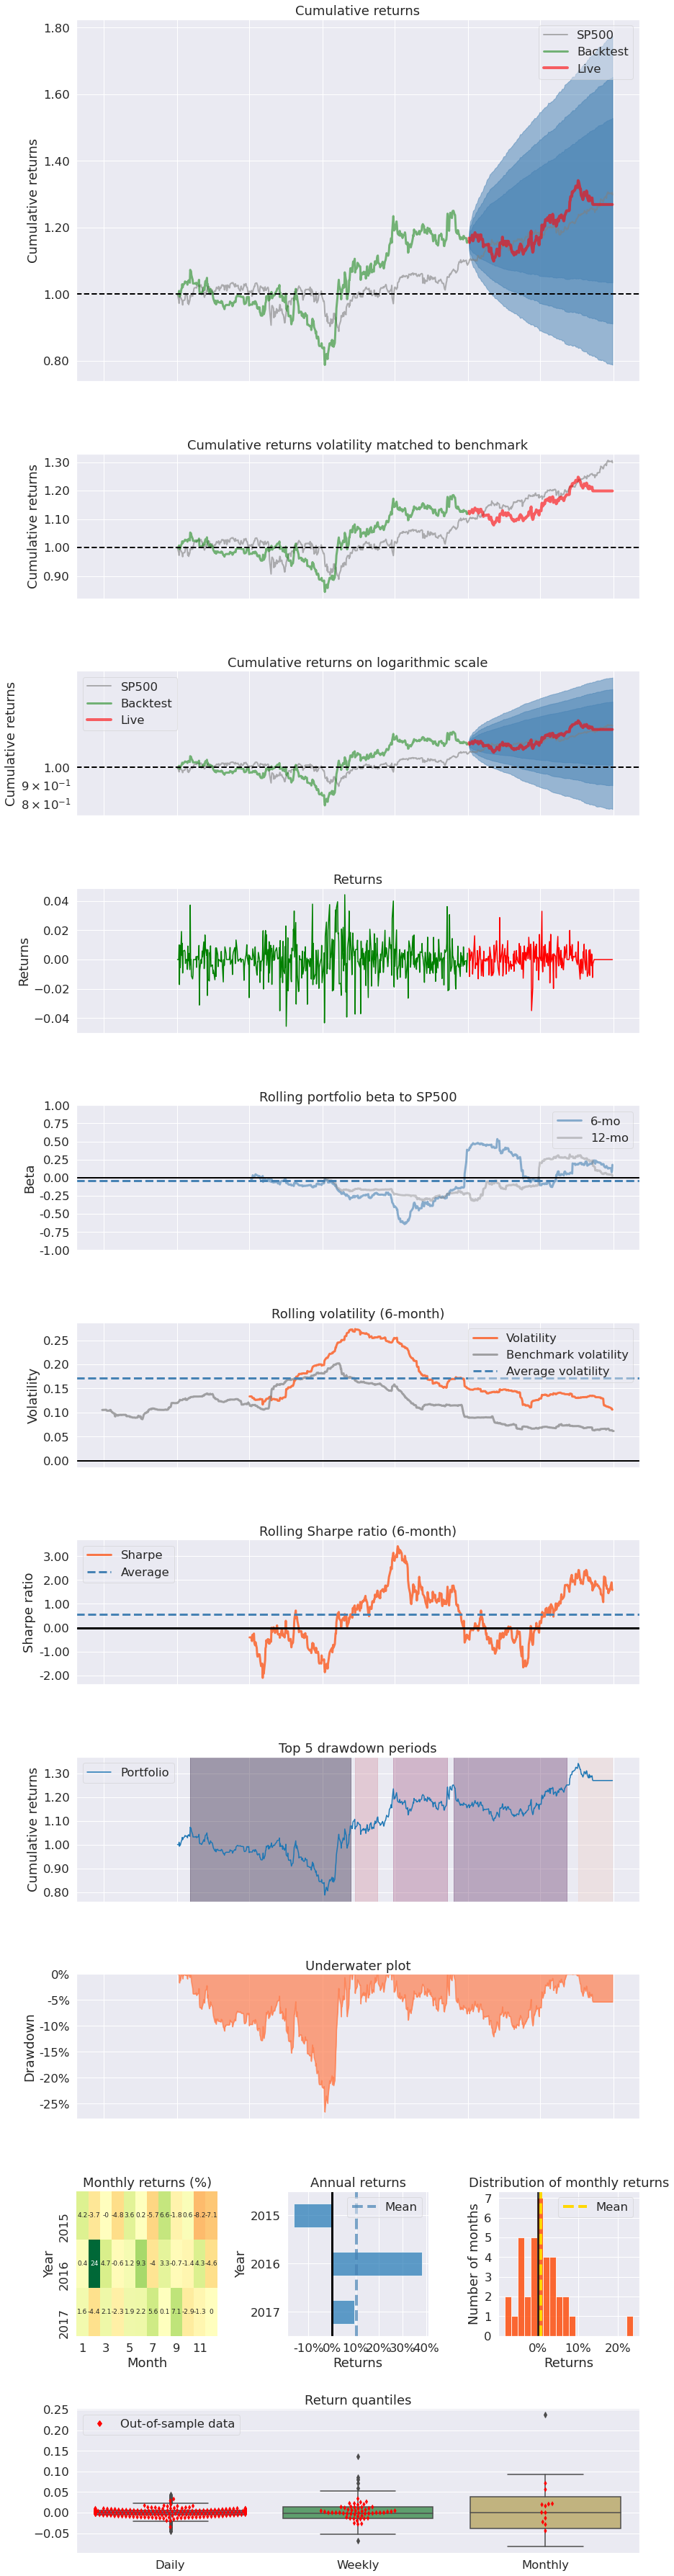

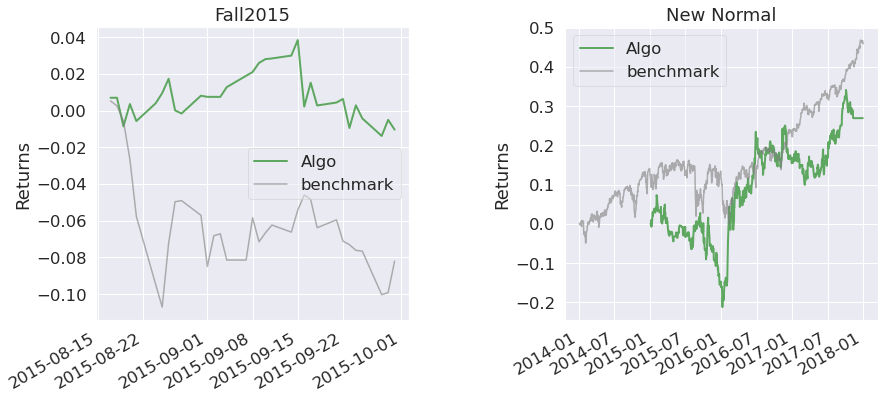

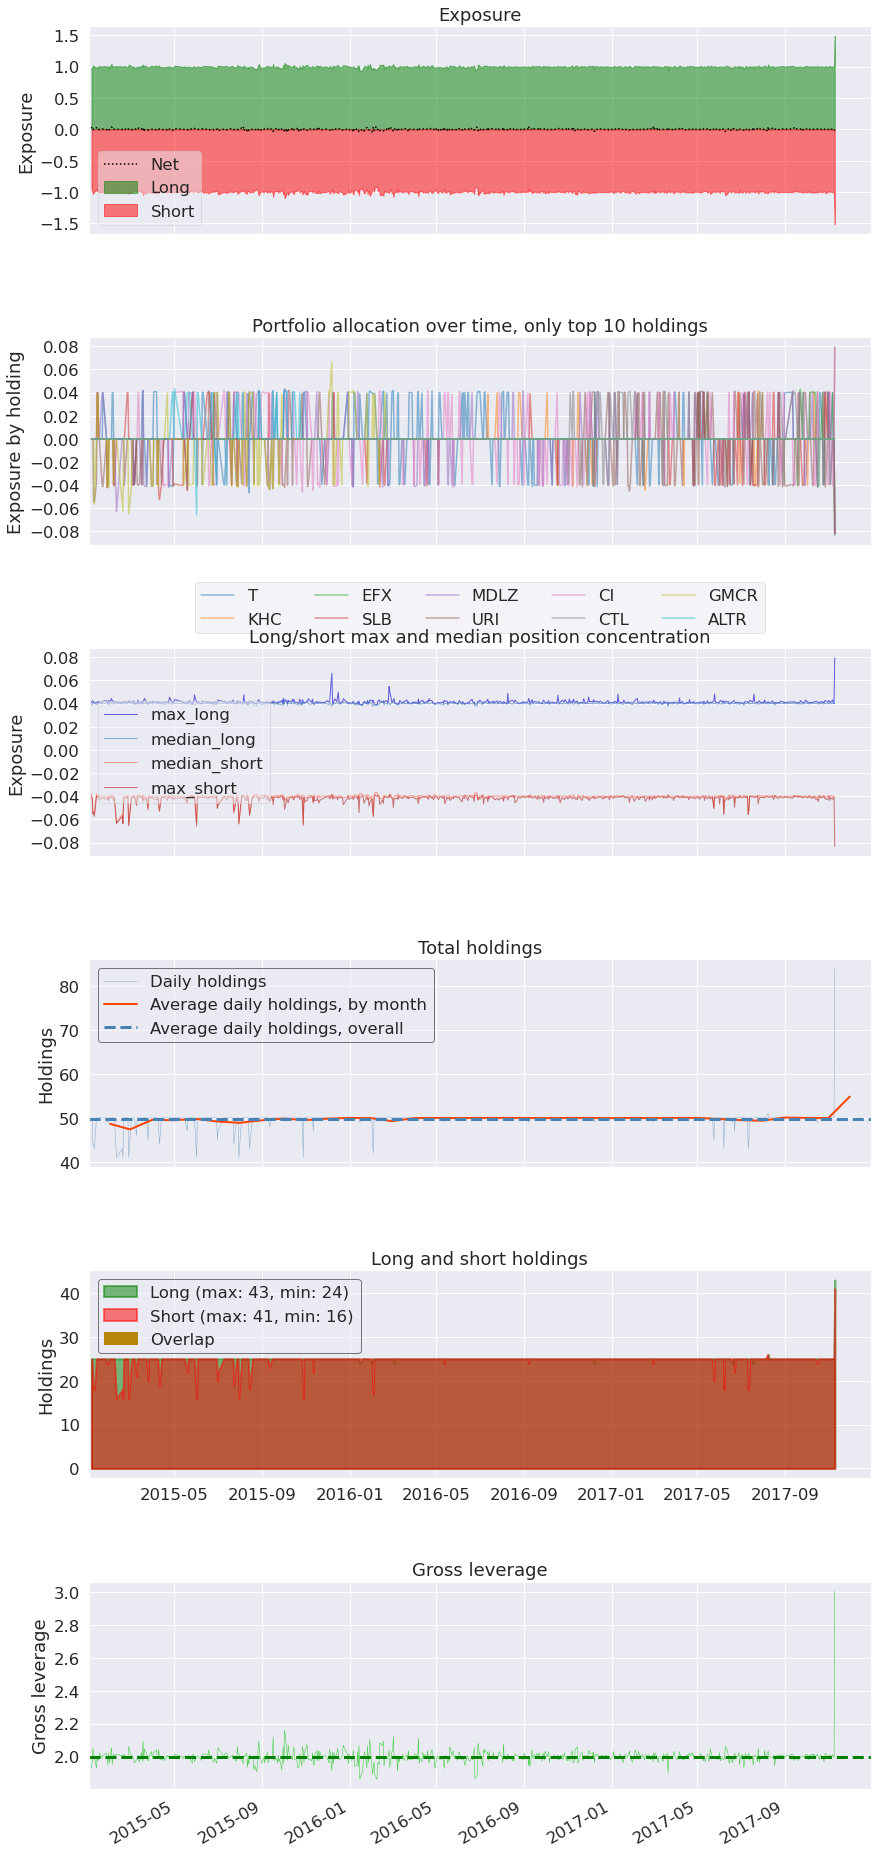

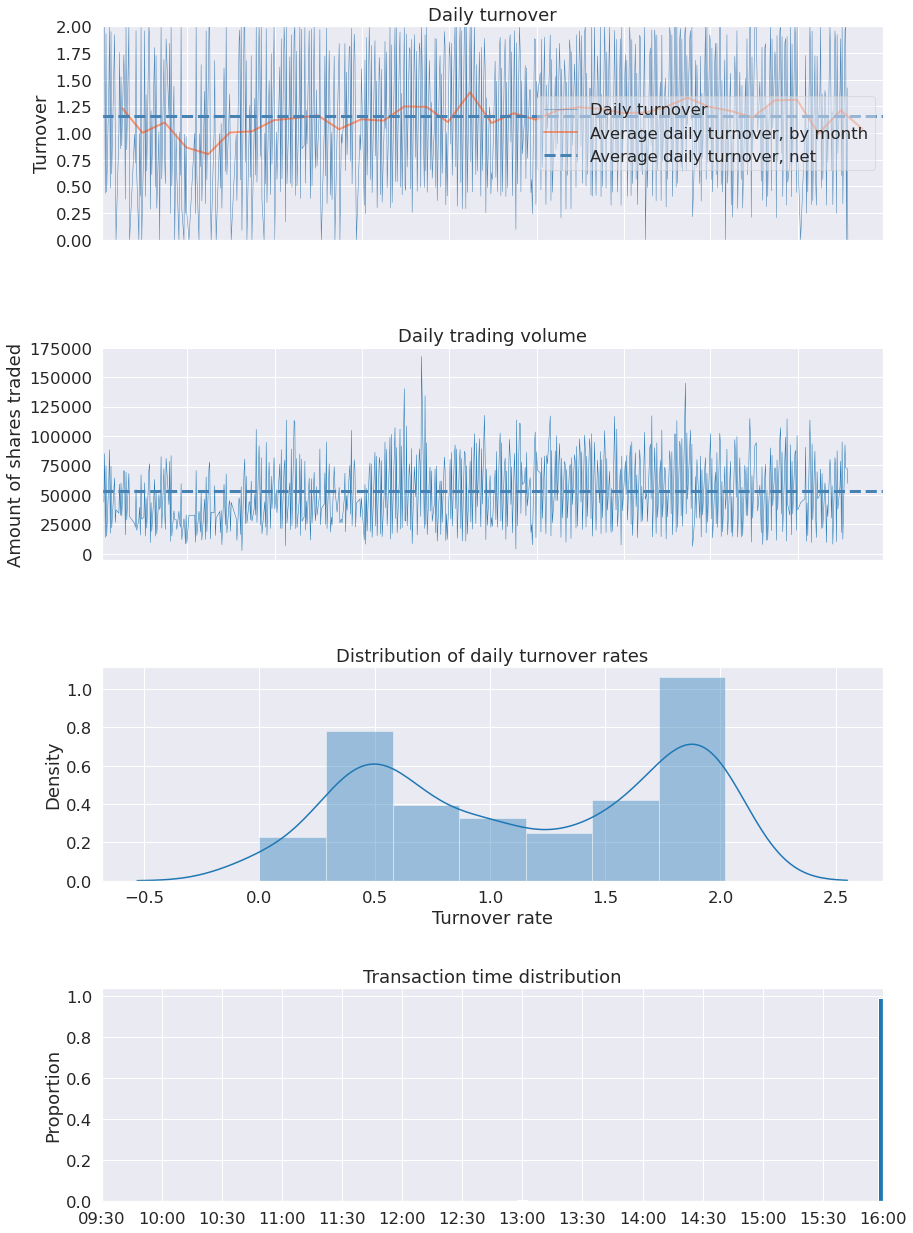

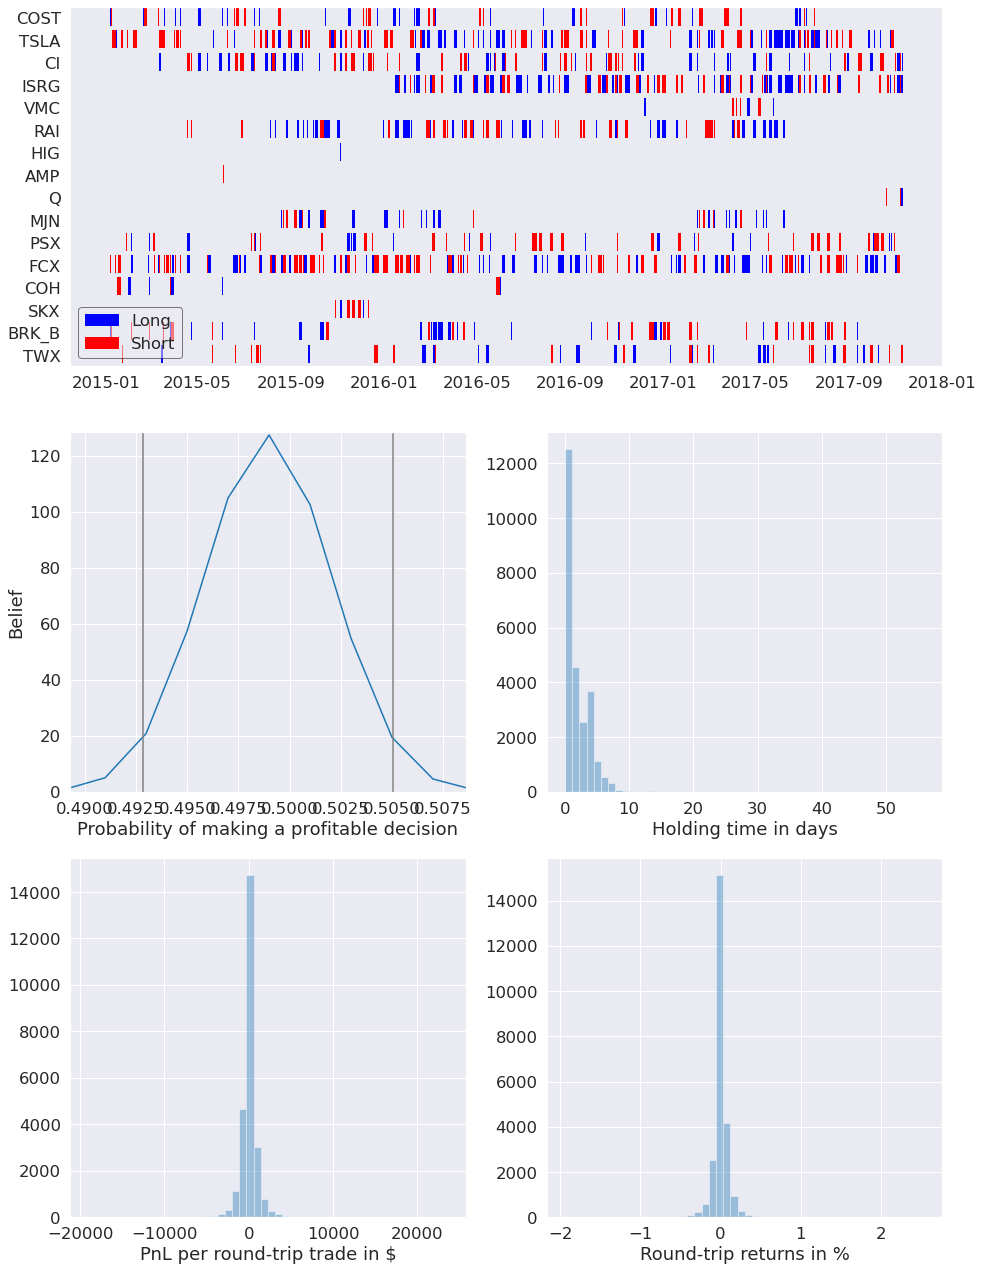

In [46]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)